# ** Gausian Mixture Model**
---

---


**PROGRAMMING SECTION**
---


For all of the following, program the solution yourself. Don't just call a library function that does the whole question for you, or you'll get zero (no, that doesn't mean you can't use any library functions, but it does mean that you have to show you understand how to compute the answer yourself).

-----------

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #This is for 3d scatter plots.
from scipy.stats import multivariate_normal
import math
import random
import functools

We're going to implement an algorithm to model data with a mixture of gaussians. 

Remember the simplified EM algorithm in assignment 2 for k-means? Well, we're going to implement something similar.

The more complex aspect of this all is that your program must also correctly estimate the covariance matrices of the 2-dimensional gaussian components involved, as well as their means.

Not only this, but the "distance" of each of your data points (a row $d_i$ of $D$) from a gaussian $k$, is the probability of that point given that gaussian $p(d_i \mid k)$. 

Run the below cell to load the data we'll be using.

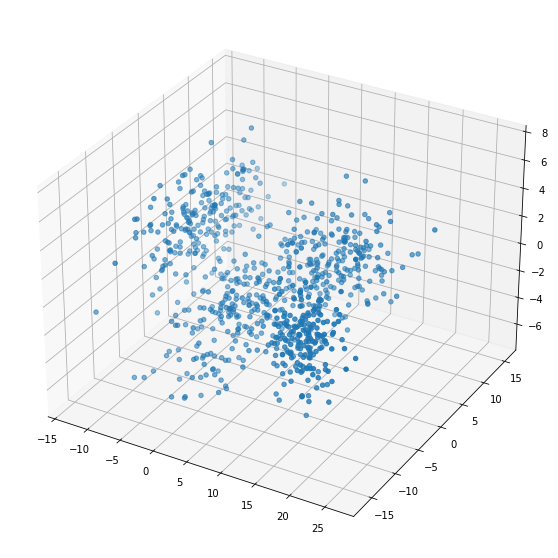

In [2]:
X = np.load("./data.npy")
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:, 2])
plt.show()

First off, some definitions:

$X$ is a dataset contains 800 data. Each data has 5 dimensions. The contribution of first three dimensions represented by a three dimensional Gaussian Mixture Model. The forth and fifth dimensions represented by another two dimensional GMM. 

**You only need the first three dimensions of the data in task 1 through 5. The fourth and fifth dimensions are for task 6 only.**.

$K$ is the total number of gaussians. This is just like the $K$ means you had for k-means in assignment 2. Each gaussian is named $k$, where $k$ is the unique number associated with that gaussian. For example, the first gaussian is $k = 1$. Each $k$ has a mean and covariance matrix associated with it. This allows you to construct a gaussian which is just a formula which can be used to generate data points or to compute the probability that a given data point is generated from this gaussian (look up generative models if you're curious to learn more). For this purpose, you can use np.random.multivariate_normal().

$\Sigma$ is a list of covariance matrices $\Sigma_k \in \mathbb{R}^{m \times m}$, which are symmetric positive semidefinite matrices.

$\mu$ is a list of means, each one $\mu_k \in \mathbb{R}^{m}$ associated with gaussian $k$.

$N$ is the total number of datapoints.

$responsibilities \in [0, 1]^{N \times K}$ is a matrix. Every column $k$ of $responsibilities$ is associated with the $k^{th}$ gaussian. Each element $r_{ik}$ of the $k^{th}$ column is the probability of the $i^{th}$ datapoint $x_i$ (the $i^{th}$ row of $X$) given the gaussian $k$.

$N_k$ is the sum of the $k^{th}$ column of $responsibilities$. In other words, there is one $N_k$ for each gaussian. $N_k = \sum_i r_{ik}$.

$\pi$ is a list of probabilities, 1 associated with each gaussian. $\pi_k$ is the probability of gaussian $k$. $\pi_k = \frac{N_k}{N}$.

---

   **TASK 1:** Complete the below function to initialise your parameters. You will need to generate:
   1. A list $\mu$ of $K$ means, each of which is in $\mathbb{R}^{m}$.
   2. A list $\Sigma$ of $K$ covariance matrices in $\mathbb{R}^{m \times m}$. Remember, covariance matrices must be symmetric positive semidefinite.
   3. A list $\pi$ of $K$ probabilities $\pi_k$. They should be initialised at $\frac{1}{K}$ (uniformly distributed at first).

Do not hard code parameters. You should generate them with some randomness, and your code must work for any $m$, $k$ and $N$.

You need to intelligently select $\mu_k$ just like you did with k-means. Poorly initialised parameters may result in an entirely broken EM algorithm.

**REPEAT: You only need the first three dimensions of the data in task 1 through 5. The fourth and fifth dimensions are for task 6 only.**.

---

In [3]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)


def initialise_parameters(X, K):
    dimension = X.shape[1]
    single_array = np.zeros((K, dimension, dimension))
    sigma = single_array

    for x in range(K):
        # b = np.random.randint(0, 9 + 1, size=(dimension, dimension))
        b = np.random.uniform(low=-50.0, high=50.0, size=(dimension, dimension))
        b_symm = (b + b.T) / 2
        while not is_pos_def(b_symm):
            b = np.random.uniform(low=-50.0, high=50.0, size=(dimension, dimension))
            b_symm = (b + b.T) / 2
        sigma[x] = b_symm

    mean_array = np.zeros((K, dimension))
    length = len(X)
    sums = (np.sum(X, axis=0))
    final_sum = sums / length
    for row in range(K):
        mean_array[row] = np.random.normal(final_sum, 2.5)

    mu = mean_array

    pi_array = np.zeros(K)
    for x in range(len(pi_array)):
        pi_array[x] = 1 / K
    pi = pi_array
    return sigma, mu, pi


    
K = 4
sigma, mu, pi = initialise_parameters(X[:, :3], K)
print('\nSigma: \n', sigma)
print('\nMu: \n', mu)
print('\nPi: \n', pi)


Sigma: 
 [[[ 27.25379345 -26.93662243  -8.62059739]
  [-26.93662243  47.60664114  22.29653502]
  [ -8.62059739  22.29653502  13.83184104]]

 [[ 42.39125944 -36.78243533 -10.68635883]
  [-36.78243533  46.49394146   8.28064344]
  [-10.68635883   8.28064344  48.48768396]]

 [[ 40.57504837   1.01179614  20.70779827]
  [  1.01179614  11.98010467   3.7647398 ]
  [ 20.70779827   3.7647398   39.03967198]]

 [[ 25.81708336  -2.64887019   5.82156162]
  [ -2.64887019  20.98321025 -11.7212322 ]
  [  5.82156162 -11.7212322   42.87276532]]]

Mu: 
 [[ 3.34681628  2.94972033 -1.6956854 ]
 [ 5.48192913  2.81891709 -0.63431425]
 [ 4.41360465 -2.03298893  5.26053705]
 [ 4.47575852  1.82936057 -2.29565696]]

Pi: 
 [0.25 0.25 0.25 0.25]


$E\_step$ computes the matrix $responsibilities \in [0, 1]^{N \times K}$, where $N$ is the number of data points, and $K$ is the number of gaussians you're attempting to cluster the data with. Each gaussian will be associated with a column of $responsibilities$. As your algorithm runs, each row represents a data point $x_i$, and each column of that row will contain the probability that $x_i$ came from that gaussian, $p(x_i \mid k)$, signifying the extent to which this datapoint $x_i$ has been assigned to the gaussian associated with that column. 

---

**TASK 2:** Implement $E\_step(\pi, \mu, \Sigma, X) = responsibilities$, which updates the $responsibilities$ matrix.

Remember, which gaussian a datapoint is assigned to depends on the probability of that datapoint given that gaussian.

You cannot use euclidean distance like you did with the k-means algorithm in assignment 3.

**HINT:** 
- Each element of responsibilities $r_{ik} = \frac{\pi_k \mathcal{N}(x_i \mid \mu_k \Sigma_k)}{\sum_j \pi_j \mathcal{N}(x_i \mid \mu_j \Sigma_j)}$, where $x_i$ is the $i^{th}$ row of $X$.
- https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.multivariate_normal.html
- Use $multivariate\_normal.pdf(x, \mu_k, \Sigma_k)$

---

In [4]:
def E_step(pi, mu, sigma, X):

    x_length = len(pi)
    y_length = len(X)
    r = np.zeros((y_length, x_length))
    denom_array = np.zeros(x_length)
    for k2 in range(len(pi)):
        counter = 0
        for row in range(len(X)):
            for k in range(len(pi)):
                if np.shape(mu[k]) == (3, 1):
                    answering = np.zeros(len(mu[k]))
                    for x in range(len(mu[k])):
                        answering[x] = mu[k][x]
                
                    denom_array[k] = pi[k2] * multivariate_normal.pdf(X[row], mean=answering, cov=sigma[k],allow_singular=True)
                else:
                    denom_array[k] = pi[k2] * multivariate_normal.pdf(X[row], mean=mu[k], cov=sigma[k],allow_singular=True)

            sum = np.sum(denom_array)
            answer = denom_array[k2] / (sum)
            r[counter][k2] = answer
            counter += 1

    return r

responsibilities = E_step(pi, mu, sigma, X[:, :3])
print(responsibilities)

[[2.19378028e-04 7.44751721e-01 1.40515789e-01 1.14513111e-01]
 [4.36898038e-06 9.94159933e-01 3.05855105e-03 2.77714715e-03]
 [1.47524940e-03 9.96307451e-01 9.26188469e-04 1.29111150e-03]
 ...
 [4.26505598e-01 2.45344632e-01 5.47445401e-02 2.73405230e-01]
 [2.67091070e-01 2.48164375e-01 7.13215976e-02 4.13422957e-01]
 [1.19195106e-01 3.95524505e-01 2.47485905e-02 4.60531799e-01]]


---

**TASK 3:** Implement $M\_step(responsibilities, X) = \mu, \Sigma, \pi$ which returns the updated means and covariances for all of the $k$ gaussians, along with the priors $\pi$.

**HINT:** 
- https://docs.scipy.org/doc/numpy/reference/generated/numpy.outer.html

---

In [5]:
def M_step(r, X):
    alpha, num_of_indiv_vect_length = X.shape
    calm, k_col = r.shape
    mean = np.zeros((k_col, num_of_indiv_vect_length, 1))
    for k_col in range(k_col):
        for k in range(num_of_indiv_vect_length):
            upper = 0
            lower = 0
            for row in range(len(X)):
                upper = upper + (X[row][k]) * (r[row][k_col])
                lower = lower + r[row][k_col]

            else:
                answer_box = upper / lower
                mean[k_col][k] = answer_box

    mu = mean

    ######################################
    calm, k_col = r.shape
    empty_sigma = np.zeros((k_col, num_of_indiv_vect_length, num_of_indiv_vect_length))

    for x in range(k_col):
        this_matrix = np.zeros((num_of_indiv_vect_length, num_of_indiv_vect_length))
        lower_val = 0
        for row in range(len(X)):
            value = r[row][x]
            lower_val = lower_val + value
            vector1 = (X[row].reshape(-1, 1) - mu[x])
            vector2 = (X[row].reshape(-1, 1) - mu[x]).transpose()
            matrix = np.matmul(vector1, vector2)
            this_matrix = this_matrix + matrix * value
        empty_sigma[x] = this_matrix / lower

    sigma = empty_sigma
    ##########################################
    pi_array = np.zeros(k_col)
    for col in range(k_col):
        sum = 0
        bottom_val = len(X)
        for row in range(len(X)):
            sum = sum + r[row][col]
        pi_array[col] = sum / bottom_val

    pi = pi_array
    return mu, sigma, pi

mu, sigma, pi = M_step(responsibilities, X[:, :3])
print('\nSigma: \n', sigma)
print('\nMu: \n', mu)
print('\nPi: \n', pi)


Sigma: 
 [[[ 1.64010303e+01 -7.10142160e+00 -1.86847134e-02]
  [-7.10142160e+00  9.92611786e+00  3.10174213e+00]
  [-1.86847134e-02  3.10174213e+00  2.13936024e+00]]

 [[ 6.17216614e+01 -4.87432495e+01 -2.47946692e+00]
  [-4.87432495e+01  5.63221037e+01  3.20105602e+00]
  [-2.47946692e+00  3.20105602e+00  5.74845946e+00]]

 [[ 6.61756286e+01 -1.53129922e+00 -3.49757357e+00]
  [-1.53129922e+00  2.53645006e+01  8.32205634e+00]
  [-3.49757357e+00  8.32205634e+00  1.26852623e+01]]

 [[ 7.57346168e+01  7.03987903e+00  2.71716872e+00]
  [ 7.03987903e+00  1.85565933e+01  4.08283447e+00]
  [ 2.71716872e+00  4.08283447e+00  6.30388838e+00]]]

Mu: 
 [[[ 5.30950740e+00]
  [ 1.65984026e+00]
  [-1.18405072e+00]]

 [[ 1.28547620e+01]
  [-6.30736470e+00]
  [ 2.46559745e-01]]

 [[-2.19664546e+00]
  [-3.15066304e+00]
  [-6.47341150e-02]]

 [[ 5.83993393e+00]
  [ 7.29551287e-01]
  [-1.72707567e-03]]]

Pi: 
 [0.11198543 0.30341271 0.33068533 0.25391653]


---

**TASK 4:** Implement $classify(\pi, \mu, \Sigma, x) = k$ which takes an unknown example $x \in \mathbb{R}^{m}$, the means $\mu$ and covariance matrices $\Sigma$ and the priors $\pi$, and returns $k$, the number of the gaussian which maximises the probability of $x$.

In other words, ${arg max}_k \left(p(x \mid \mu_k, \Sigma_k)\pi_k \right)$.

---

In [6]:
def classify(pi, mu, sigma, x):
    answer_array = np.zeros(len(pi))

    for row in range(len(pi)):
        answer2 = multivariate_normal.pdf(x, mean=mu[row].reshape(-1), cov=sigma[row])
        answer_array[row] = answer2 * pi[row]

    answer_final_array = np.cumsum(answer_array)
    k = np.argmax(answer_final_array)

    return k

print(classify(pi, mu, sigma, X[270, :3]))

3


---

**TASK 5:** Implement $EM(X, K, iterations) = \mu, \Sigma, \pi$ which: 
1. takes a dataset $X \in \mathbb{R}^{N \times m}$ and $K$, an integer indicating how many gaussians will be used to cluster the data, and $iterations$ the number of iterations to be performed.
2. uses all of the functions you completed above to initialise parameters and find the optimal means $\mu$, covariances $\Sigma$ and priors $\pi$ to cluster the data points (a gaussian mixture model).

---


Sigma: 
 [[[ 1.37531918e+01 -5.29756940e+00  2.15607925e+00]
  [-5.29756940e+00  3.34145979e+00 -5.53294820e-01]
  [ 2.15607925e+00 -5.53294820e-01  4.66877992e+00]]

 [[ 1.34731679e+01  4.33889730e+00  1.64527525e+00]
  [ 4.33889730e+00  1.60391406e+01  4.45836062e+00]
  [ 1.64527525e+00  4.45836062e+00  3.37541159e+00]]

 [[ 2.41400571e+00  4.91673175e+00  8.15502564e-01]
  [ 4.91673175e+00  2.57939746e+01 -9.98465937e-01]
  [ 8.15502564e-01 -9.98465937e-01  4.59569344e+00]]

 [[ 1.92656149e+01  1.30583574e-02  2.88292443e+00]
  [ 1.30583574e-02  2.16333074e+00  7.96200162e-02]
  [ 2.88292443e+00  7.96200162e-02  4.73154310e+00]]]

Mu: 
 [[[ 15.60254419]
  [-10.25266693]
  [ -0.0719151 ]]

 [[  1.10096348]
  [ -3.64268559]
  [ -2.69868397]]

 [[ -7.12839311]
  [  0.65590088]
  [  1.77295849]]

 [[ 11.52035335]
  [  2.96863687]
  [  0.64128294]]]

Pi: 
 [0.25189451 0.24774128 0.25288449 0.24747971]


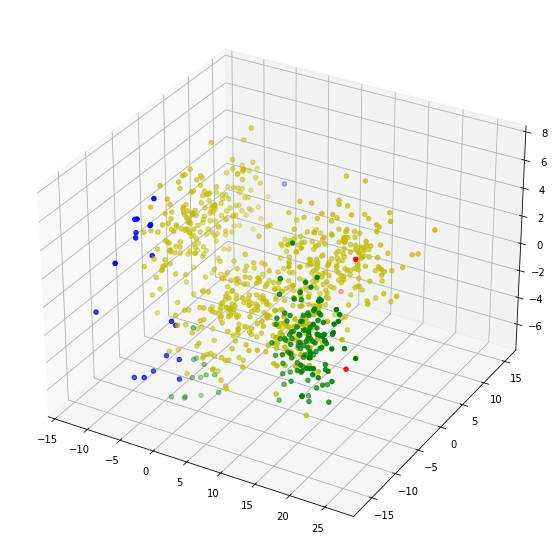

In [7]:
def EM(X, K, iterations):
    sigma_intial, mu_intial, pi_intial = initialise_parameters(X, K)
    responsibilities_01 = E_step(pi_intial, mu_intial, sigma_intial, X)
    mu_new, sigma_new, pi_new = M_step(responsibilities_01, X)
    counter = 1

    while counter < iterations:
        responsibilities_01 = E_step(pi_new, mu_new, sigma_new, X)
        mu_new, sigma_new, pi_new = M_step(responsibilities_01, X)
        counter += 1

    return mu_new, sigma_new, pi_new


#Test code. Leave it aloooooone!
iterations = 30
K = 4
mu_1, sigma_1, pi_1 = EM(X[:, :3], K, iterations)
print('\nSigma: \n', sigma_1)
print('\nMu: \n', mu_1)
print('\nPi: \n', pi_1)

def allocator(pi, mu, sigma, X, k):
    N = X.shape[0]
    cluster = []
    for ix in range(N):
        prospective_k = classify(pi, mu, sigma, X[ix, :])
        if prospective_k == k:
            cluster.append(X[ix, :])
    return np.asarray(cluster)


colours = ['r', 'g', 'b', 'y']
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')
for k in range(K):
    cluster = allocator(pi_1, mu_1, sigma_1, X[:, :3], k)
    ax.scatter(cluster[:, 0], cluster[:, 1], cluster[:, 2], c=colours[k])
plt.show()


Now we start to use the forth and fifth dimension. First, we plot the forth and fifth dimension.

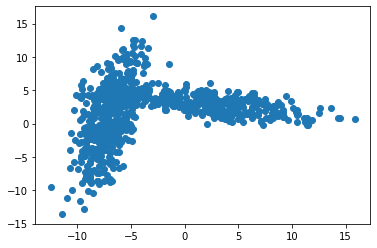

In [8]:
plt.scatter(X[:,3], X[:,4])
plt.show()

It is clearly that the number of Gaussians (K) for the second GMM equals to 2.

